<a href="https://colab.research.google.com/github/HoangNguyennnnnnn/ComputerVision/blob/main/MeanFlow_Improved_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeanFlow v3 - Fixed (Smaller Model)

## Fixes:
- Reduced model: ch=64 (~2M params)
- Batch size: 64
- Removed some attention layers

> Restart runtime first!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.func import jvp
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
import math, os, copy
import numpy as np

torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [2]:
# ========== CONFIG ==========
CLASS_ID = 1  # automobile
BATCH_SIZE = 64  # Reduced!
EPOCHS = 500
LR = 1e-4
SAVE_EVERY = 25
R_NEQ_T_RATIO = 0.25
ADAPTIVE_P = 1.0
EMA_DECAY = 0.9999
RESUME = True
# ============================
print(f"Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")

Batch: 64, Epochs: 500


In [3]:
# Dataset
def get_dl():
    tf = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    ds = CIFAR10("./data", train=True, download=True, transform=tf)
    idx = [i for i,(_, l) in enumerate(ds) if l == CLASS_ID]
    return DataLoader(Subset(ds, idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

dl = get_dl()
print(f"Dataset: {len(dl.dataset)} images, {len(dl)} batches")

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


Dataset: 5000 images, 78 batches


In [4]:
# Smaller Model
class SinEmbed(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
    def forward(self, t):
        h = self.d // 2
        f = torch.exp(-math.log(10000) * torch.arange(h, device=t.device) / h)
        e = t[:, None] * f * 1000
        return torch.cat([e.sin(), e.cos()], -1)

class AdaGN(nn.Module):
    def __init__(self, ch, td):
        super().__init__()
        self.norm = nn.GroupNorm(8, ch, affine=False)
        self.proj = nn.Linear(td, ch * 2)
        nn.init.zeros_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)
    def forward(self, x, emb):
        h = self.norm(x)
        s, b = self.proj(emb).chunk(2, -1)
        return h * (1 + s[:,:,None,None]) + b[:,:,None,None]

class ResBlock(nn.Module):
    def __init__(self, ci, co, td):
        super().__init__()
        self.agn1 = AdaGN(ci, td)
        self.c1 = nn.Conv2d(ci, co, 3, padding=1)
        self.agn2 = AdaGN(co, td)
        self.c2 = nn.Conv2d(co, co, 3, padding=1)
        self.skip = nn.Conv2d(ci, co, 1) if ci != co else nn.Identity()
        nn.init.zeros_(self.c2.weight)
        nn.init.zeros_(self.c2.bias)
    def forward(self, x, emb):
        h = self.c1(F.silu(self.agn1(x, emb)))
        h = self.c2(F.silu(self.agn2(h, emb)))
        return h + self.skip(x)

class UNet(nn.Module):
    def __init__(self, ch=64, td=128):  # Smaller!
        super().__init__()
        self.te = nn.Sequential(SinEmbed(td), nn.Linear(td, td*2), nn.SiLU(), nn.Linear(td*2, td))
        self.de = nn.Sequential(SinEmbed(td), nn.Linear(td, td*2), nn.SiLU(), nn.Linear(td*2, td))

        td2 = td * 2
        self.cin = nn.Conv2d(3, ch, 3, padding=1)
        self.e1 = ResBlock(ch, ch, td2)
        self.d1 = nn.Conv2d(ch, ch, 3, stride=2, padding=1)
        self.e2 = ResBlock(ch, ch*2, td2)
        self.d2 = nn.Conv2d(ch*2, ch*2, 3, stride=2, padding=1)
        self.mid = ResBlock(ch*2, ch*2, td2)
        self.u2 = nn.Upsample(scale_factor=2)
        self.dec2 = ResBlock(ch*4, ch, td2)
        self.u1 = nn.Upsample(scale_factor=2)
        self.dec1 = ResBlock(ch*2, ch, td2)
        self.cout = nn.Sequential(nn.GroupNorm(8,ch), nn.SiLU(), nn.Conv2d(ch,3,3,padding=1))
        nn.init.zeros_(self.cout[-1].weight)
        nn.init.zeros_(self.cout[-1].bias)

    def forward(self, z, r, t):
        emb = torch.cat([self.te(t), self.de(t-r)], -1)
        h = self.cin(z)
        h1 = self.e1(h, emb)
        h = self.d1(h1)
        h2 = self.e2(h, emb)
        h = self.d2(h2)
        h = self.mid(h, emb)
        h = self.u2(h)
        h = torch.cat([h, h2], 1)
        h = self.dec2(h, emb)
        h = self.u1(h)
        h = torch.cat([h, h1], 1)
        h = self.dec1(h, emb)
        return self.cout(h)

model = UNet(ch=64).to(device)
print(f"Model: {sum(p.numel() for p in model.parameters())/1e6:.2f}M params")

Model: 1.80M params


In [5]:
# Utilities
class EMA:
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {k: v.clone() for k, v in model.state_dict().items()}
    def update(self, model):
        for k, v in model.state_dict().items():
            self.shadow[k] = self.decay * self.shadow[k] + (1-self.decay) * v
    def apply(self, model):
        self.backup = copy.deepcopy(model.state_dict())
        model.load_state_dict(self.shadow)
    def restore(self, model):
        model.load_state_dict(self.backup)

def sample_t_r(B, dev):
    u = torch.randn(B, device=dev) - 0.4
    t = torch.sigmoid(u).clamp(0.001, 0.999)
    r = torch.rand(B, device=dev) * t
    mask = torch.rand(B, device=dev) < (1 - R_NEQ_T_RATIO)
    return t, torch.where(mask, t, r)

def loss_fn(model, x):
    B = x.shape[0]
    t, r = sample_t_r(B, x.device)
    eps = torch.randn_like(x)
    te = t[:,None,None,None]
    z = (1-te)*x + te*eps
    v = eps - x

    u, dudt = jvp(lambda a,b,c: model(a,b,c), (z,r,t), (v, torch.zeros_like(r), torch.ones_like(t)))
    tr = (t-r)[:,None,None,None]
    tgt = v - tr * dudt
    err = u - tgt.detach()

    if ADAPTIVE_P > 0:
        with torch.no_grad():
            d2 = (err**2).mean(dim=(1,2,3))
            w = 1.0 / (d2 + 1e-4)**ADAPTIVE_P
            w = w / w.mean()
        return (w[:,None,None,None] * err**2).mean()
    return (err**2).mean()

@torch.no_grad()
def sample_1step(model, n):
    e = torch.randn(n, 3, 32, 32, device=device)
    u = model(e, torch.zeros(n,device=device), torch.ones(n,device=device))
    return ((e-u).clamp(-1,1)+1)/2

@torch.no_grad()
def sample_euler(model, n, steps=20):
    z = torch.randn(n, 3, 32, 32, device=device)
    dt = 1.0/steps
    for i in range(steps):
        t = torch.ones(n,device=device)*(1-i*dt)
        r = (t-dt).clamp(0)
        z = z - model(z, r, t)*dt
    return (z.clamp(-1,1)+1)/2

# Test
test_x = torch.randn(2, 3, 32, 32, device=device)
test_loss = loss_fn(model, test_x)
print(f"Test loss: {test_loss.item():.4f}")
del test_x, test_loss
torch.cuda.empty_cache()

Test loss: 1.9806


In [6]:
# Setup
os.makedirs("results", exist_ok=True)
CKPT = "results/ckpt.pth"
BEST = "results/best.pth"

model = UNet(ch=64).to(device)
opt = AdamW(model.parameters(), lr=LR, betas=(0.9, 0.95))
ema = EMA(model, EMA_DECAY)

start_ep = 0
loss_hist = []
best_loss = float("inf")

if RESUME and os.path.exists(CKPT):
    ck = torch.load(CKPT, map_location=device)
    model.load_state_dict(ck["model"])
    opt.load_state_dict(ck["opt"])
    ema.shadow = ck["ema"]
    start_ep = ck["epoch"]
    loss_hist = ck["loss_hist"]
    best_loss = ck.get("best_loss", float("inf"))
    print(f"Resumed from epoch {start_ep}")

print(f"Model: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Model: 1.80M


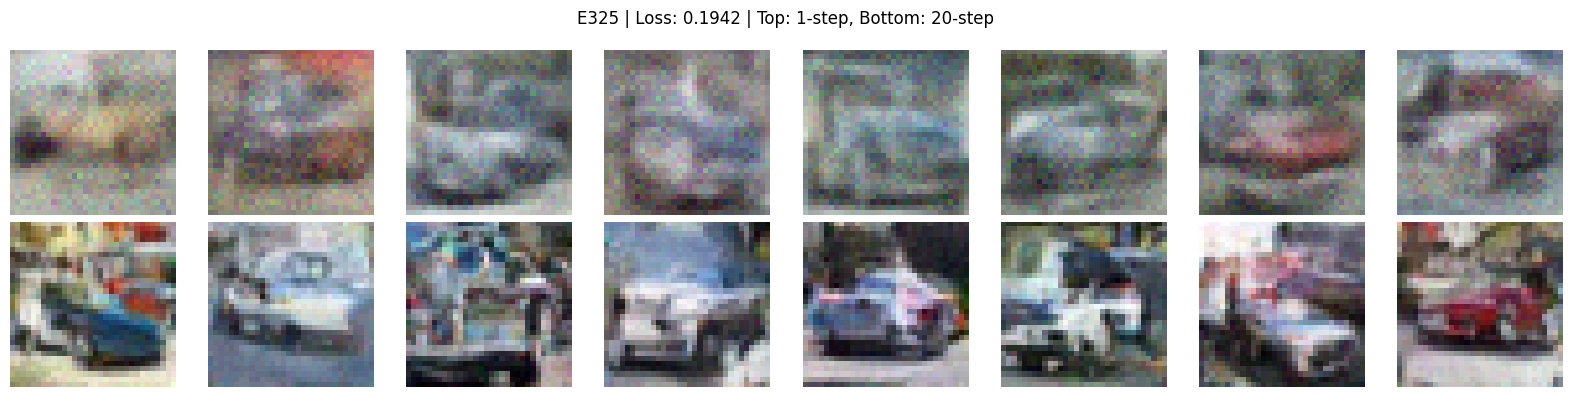

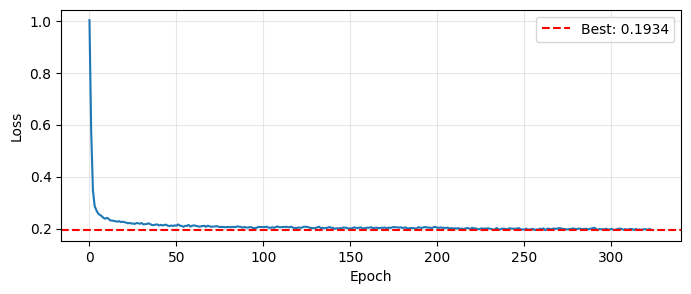

E326:   0%|          | 0/78 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
# Train
dl = get_dl()

for ep in range(start_ep, EPOCHS):
    model.train()
    el = 0
    nb = 0

    for x, _ in tqdm(dl, desc=f"E{ep+1}", leave=False):
        x = x.to(device)
        loss = loss_fn(model, x)

        if torch.isnan(loss) or loss.item() > 100:
            continue

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        ema.update(model)

        el += loss.item()
        nb += 1

    avg = el / max(nb, 1)
    loss_hist.append(avg)

    if (ep+1) % 5 == 0 or ep == start_ep:
        print(f"E{ep+1:3d} | Loss: {avg:.4f}" + (" *best*" if avg < best_loss else ""))

    if avg < best_loss and avg > 0:
        best_loss = avg
        torch.save({"model": model.state_dict(), "ema": ema.shadow, "epoch": ep+1, "loss": avg}, BEST)

    if (ep+1) % SAVE_EVERY == 0:
        torch.save({"epoch": ep+1, "model": model.state_dict(), "opt": opt.state_dict(),
                    "ema": ema.shadow, "loss_hist": loss_hist, "best_loss": best_loss}, CKPT)

        model.eval()
        ema.apply(model)
        s1 = sample_1step(model, 8)
        s20 = sample_euler(model, 8, 20)
        ema.restore(model)

        clear_output(wait=True)
        fig, ax = plt.subplots(2, 8, figsize=(16, 4))
        fig.suptitle(f"E{ep+1} | Loss: {avg:.4f} | Top: 1-step, Bottom: 20-step")
        for i in range(8):
            ax[0,i].imshow(np.clip(s1[i].cpu().permute(1,2,0).numpy(),0,1)); ax[0,i].axis("off")
            ax[1,i].imshow(np.clip(s20[i].cpu().permute(1,2,0).numpy(),0,1)); ax[1,i].axis("off")
        plt.tight_layout(); plt.savefig(f"results/e{ep+1}.png", dpi=150); plt.show()

        plt.figure(figsize=(8,3))
        plt.plot(loss_hist)
        plt.axhline(y=best_loss, color="r", linestyle="--", label=f"Best: {best_loss:.4f}")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(alpha=0.3)
        plt.savefig("results/loss.png"); plt.show()
        torch.cuda.empty_cache()

print(f"Done! Best: {best_loss:.4f}")

Loaded best: epoch 263, loss 0.1934


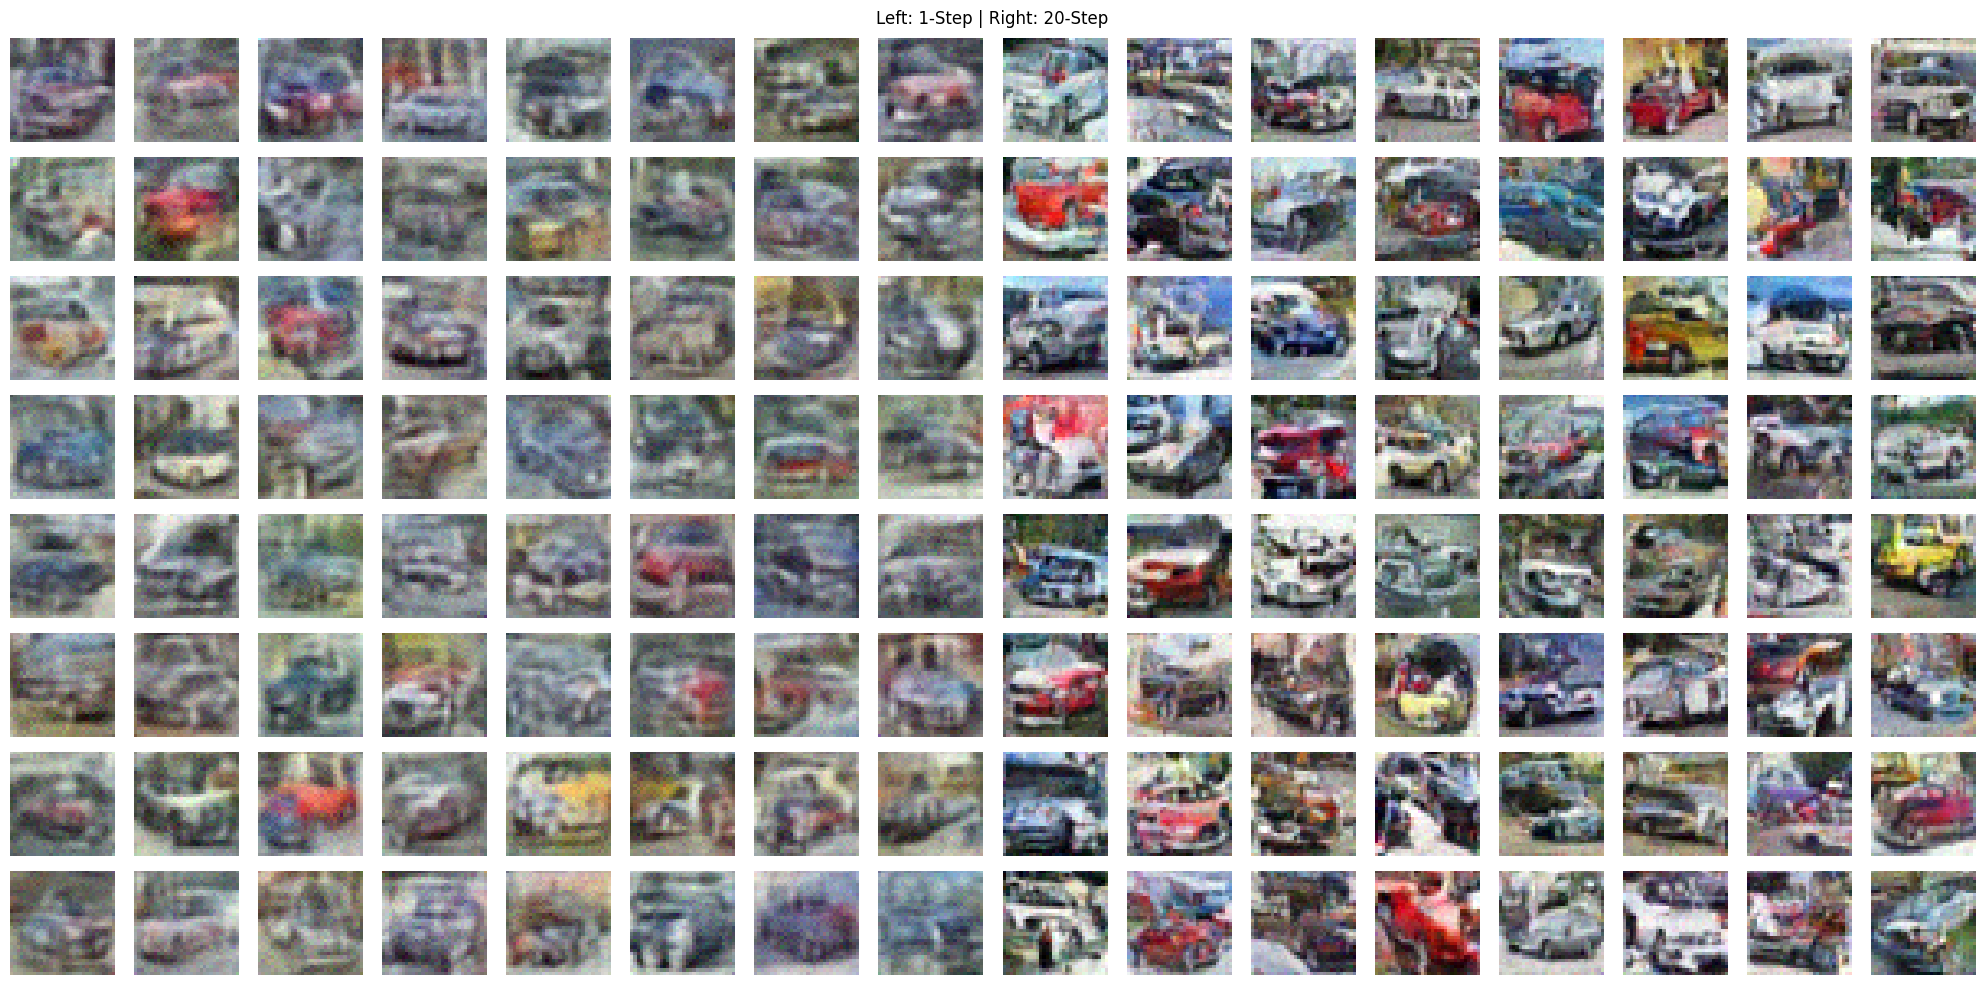

In [8]:
# Final
if os.path.exists(BEST):
    ck = torch.load(BEST, map_location=device)
    model.load_state_dict(ck.get("ema", ck["model"]))
    print(f"Loaded best: epoch {ck['epoch']}, loss {ck['loss']:.4f}")

model.eval()
s1 = sample_1step(model, 64)
s20 = sample_euler(model, 64, 20)

fig, ax = plt.subplots(8, 16, figsize=(20, 10))
fig.suptitle("Left: 1-Step | Right: 20-Step")
for i in range(64):
    r, c = i//8, i%8
    ax[r,c].imshow(np.clip(s1[i].cpu().permute(1,2,0).numpy(),0,1)); ax[r,c].axis("off")
    ax[r,c+8].imshow(np.clip(s20[i].cpu().permute(1,2,0).numpy(),0,1)); ax[r,c+8].axis("off")
plt.tight_layout(); plt.savefig("results/final.png", dpi=150); plt.show()